In [ ]:
! pip install kaggle

In [2]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d grassknoted/asl-alphabet

asl-alphabet.zip: Skipping, found more recently modified local copy (use --force to force download)


Unzipping the Dataset

In [ ]:
! unzip '/content/asl-alphabet.zip'

# Importing Necessary Libraries 

In [7]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib as plt
%matplotlib inline
import cv2
import os

In [8]:
training_dir="/content/asl_alphabet_train/asl_alphabet_train"
categories=sorted(os.listdir(training_dir))
print(categories)
print(len(categories))

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
29


In [9]:
labels=[i for i in range(len(categories))]

In [10]:
label_dict=dict(zip(categories, labels))

In [11]:
data_list=[]
labels_list=[]

# Image Preprocessing

In [12]:
from PIL import Image,ImageOps
for i in categories:
    folder_path=os.path.join(training_dir, i) #path to each sub folder
    img_names=os.listdir(folder_path)   #all images in each sub folder
    for img_name in img_names:
        img_path=os.path.join(folder_path, img_name)
        img = Image.open(img_path)
        img = img.resize((32,32))
        img = np.array(img)
        data_list.append(img)
        labels_list.append(label_dict[i])

In [13]:
data_list[0].shape

(32, 32, 3)

In [14]:
data = np.array(data_list)
labels = np.array(labels_list)
print("Done")
print(data.shape)

Done
(87000, 32, 32, 3)


#Data Visualization

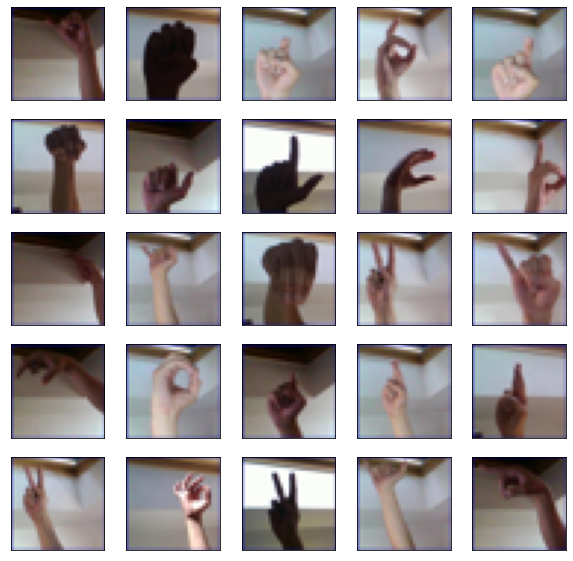

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data[np.random.randint(87000)], cmap=plt.cm.binary)
    
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


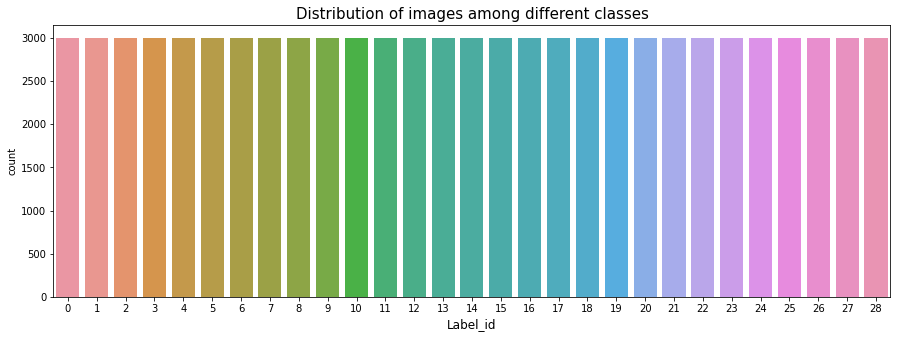

In [16]:
import seaborn as sns
plt.figure(figsize=(15,5))
sns.countplot(labels)
plt.title('Distribution of images among different classes', fontsize = 15)
plt.xlabel('Label_id', fontsize=12)
plt.show()

In [17]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16

In [18]:
print(data.shape, labels.shape)
#Splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

#Converting the labels into one hot encoding
y_train = to_categorical(y_train, 29)
y_test = to_categorical(y_test, 29)

(87000, 32, 32, 3) (87000,)
(69600, 32, 32, 3) (17400, 32, 32, 3) (69600,) (17400,)


In [19]:
base_model = VGG16(include_top=False,
                         input_shape=(32,32,3),
                         weights='imagenet',
                         pooling="avg"
                     )

In [20]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

base_model.trainable = False
image_input = Input(shape=(32, 32, 3))

x = base_model(image_input,training = False)

x = Dense(128,activation = "sigmoid")(x)
x = Dropout(0.2)(x)

image_output = Dense(29, activation="softmax")(x)

model = Model(image_input,image_output)
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [21]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=3, monitor="val_loss",)
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/20
1088/1088 [==============================] - 829s 760ms/step - loss: 1.1779 - accuracy: 0.7010 - val_loss: 0.4588 - val_accuracy: 0.9001
Epoch 2/20
1088/1088 [==============================] - 816s 750ms/step - loss: 0.3832 - accuracy: 0.9019 - val_loss: 0.2400 - val_accuracy: 0.9445
Epoch 3/20
1088/1088 [==============================] - 817s 751ms/step - loss: 0.2437 - accuracy: 0.9357 - val_loss: 0.1584 - val_accuracy: 0.9637
Epoch 4/20
1088/1088 [==============================] - 817s 751ms/step - loss: 0.1874 - accuracy: 0.9486 - val_loss: 0.1231 - val_accuracy: 0.9724
Epoch 5/20
1088/1088 [==============================] - 816s 750ms/step - loss: 0.1539 - accuracy: 0.9569 - val_loss: 0.0985 - val_accuracy: 0.9757
Epoch 6/20
1088/1088 [==============================] - 817s 751ms/step - loss: 0.1347 - accuracy: 0.9617 - val_loss: 0.0927 - val_accuracy: 0.9756
Epoch 7/20
1088/1088 [==============================] - 819s 753ms/step - loss: 0.1272 - accuracy: 0.9621 - val_

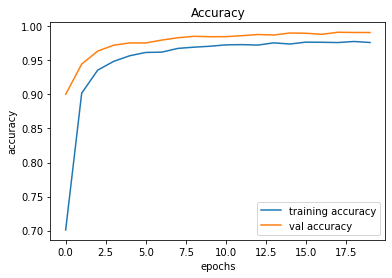

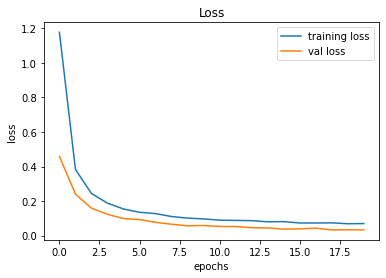

In [22]:
#plotting graphs for accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [27]:
model.evaluate(X_test, y_test, batch_size=32)

544/544 [==============================] - 180s 331ms/step - loss: 0.0326 - accuracy: 0.9910


[0.03256768360733986, 0.9909769892692566]

In [29]:
y_test_arg=np.argmax(y_test,axis=1)
Y_pred = np.argmax(model.predict(X_test),axis=1)

In [30]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test_arg, Y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       584
           1       1.00      1.00      1.00       574
           2       1.00      1.00      1.00       617
           3       1.00      0.99      0.99       589
           4       0.99      0.99      0.99       602
           5       0.99      0.99      0.99       580
           6       1.00      0.99      1.00       585
           7       0.99      1.00      1.00       587
           8       0.99      0.99      0.99       599
           9       1.00      0.99      1.00       598
          10       0.99      1.00      0.99       610
          11       1.00      1.00      1.00       609
          12       0.99      0.99      0.99       641
          13       0.99      0.99      0.99       626
          14       0.99      1.00      0.99       587
          15       1.00      0.99      1.00       568
          16       0.99      1.00      1.00       569
          17       0.99    

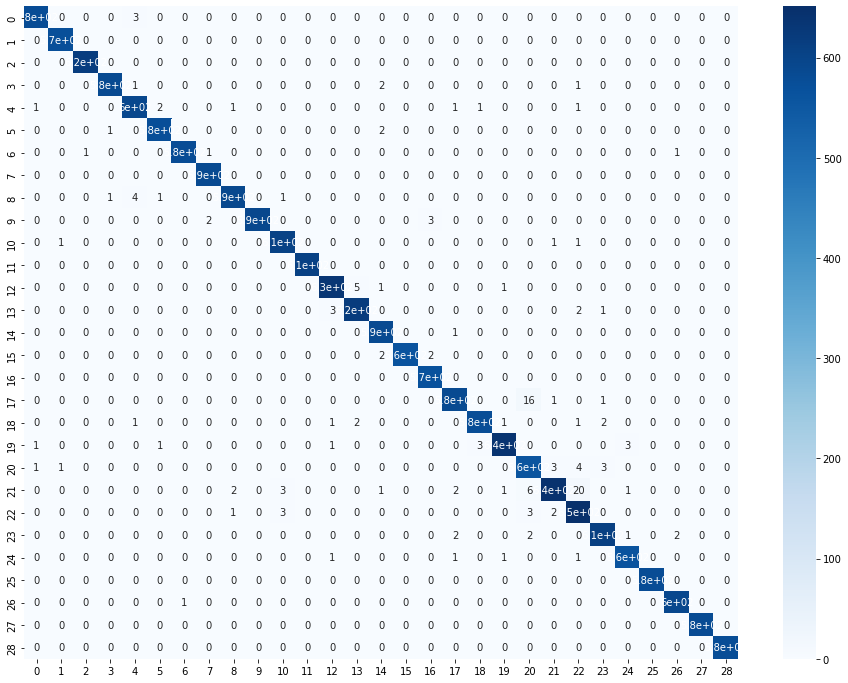

In [36]:
cm = confusion_matrix(y_test_arg, Y_pred)
plt.figure(figsize = (16,12))
ax = sns.heatmap(cm, annot=True, cmap="Blues")

In [23]:
model.save("my_h5_model.h5")